This notebook contains the K-nearest neighbors algorithm to predict Kobe's shots.

## TODO: To avoid leakage: method should only train on events that occurred prior to the shot for which you are predicting!

For more info on leakage, see:

https://www.kaggle.com/dansbecker/data-leakage


In [1]:
import numpy as np
import csv
import pandas as pd
from scipy import stats

from keras.models import Sequential
from keras.layers import Dense
import keras
from sklearn import preprocessing
import tensorflow as ft


Using TensorFlow backend.


## Load the data

In [2]:
df = pd.read_csv('../../data/data.csv')

In [3]:
df.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


## Data preprocessing

The following cell combines the two columns `minutes_remaining` and `seconds_remaining` into the new column `time_remaining`.

In [4]:
# Combine minutes and seconds remaining into decimal minutes remaining, e.g. 6.5 for 6 mins and 30 secs.
df['time_remaining'] = round(df['minutes_remaining'] + (df['seconds_remaining'] / 60), 2)
df[['time_remaining']]

,time_remaining
0,10.45
1,10.37
2,7.75
3,6.87
4,6.32
...,...
30692,6.08
30693,6.08
30694,3.47
30695,2.17


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

### Convert the data types of the columns to categoricals when relevant

In [6]:
df.iloc[0]

action_type                    Jump Shot
combined_shot_type             Jump Shot
game_event_id                         10
game_id                         20000012
lat                              33.9723
loc_x                                167
loc_y                                 72
lon                             -118.103
minutes_remaining                     10
period                                 1
playoffs                               0
season                           2000-01
seconds_remaining                     27
shot_distance                         18
shot_made_flag                       NaN
shot_type                 2PT Field Goal
shot_zone_area             Right Side(R)
shot_zone_basic                Mid-Range
shot_zone_range                16-24 ft.
team_id                       1610612747
team_name             Los Angeles Lakers
game_date                     2000-10-31
matchup                        LAL @ POR
opponent                             POR
shot_id         

In [7]:
# Categorize all columns based on their data type
categoricals = [
    'action_type',
    'combined_shot_type',
    'game_event_id', # Meaning?
    'game_id',
    'season',
    'shot_type',
    'shot_zone_area',
    'shot_zone_basic',
    'shot_zone_range',
    'team_id',
    'team_name',
    'matchup',
    'opponent'
]

temporal = [
    'game_date'
]

remaining = [
    'lat',
    'loc_x',
    'loc_y',
    'lon',
    'period',
    'shot_distance',
    'time_remaining',
    'shot_made_flag'  # y label
]

perhaps_to_exclude = [
    'shot_id',            # Just an auto-increment id, does not mean anything
    'minutes_remaining',  # Not needed, since we use the engineered field 'time_remaining'
    'seconds_remaining'   # Not needed, since we use the engineered field 'time_remaining'
]

# Convert to categorical
df[categoricals] = df[categoricals].astype('category')


In [8]:
# Show some stats per categorical column
df.describe(include='category')

,action_type,combined_shot_type,game_event_id,game_id,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,620,1559,20,2,6,7,5,1,1,74,33
top,Jump Shot,Jump Shot,2,21501228,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL @ SAS,SAS
freq,18880,23485,132,50,2318,24271,13455,12625,9398,30697,30697,1020,1978


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   action_type         30697 non-null  category
 1   combined_shot_type  30697 non-null  category
 2   game_event_id       30697 non-null  category
 3   game_id             30697 non-null  category
 4   lat                 30697 non-null  float64 
 5   loc_x               30697 non-null  int64   
 6   loc_y               30697 non-null  int64   
 7   lon                 30697 non-null  float64 
 8   minutes_remaining   30697 non-null  int64   
 9   period              30697 non-null  int64   
 10  playoffs            30697 non-null  int64   
 11  season              30697 non-null  category
 12  seconds_remaining   30697 non-null  int64   
 13  shot_distance       30697 non-null  int64   
 14  shot_made_flag      25697 non-null  float64 
 15  shot_type           30697 non-null  

## Encode categoricals to integers

In [10]:
cat_cols = df[categoricals]
cat_cols

,action_type,combined_shot_type,game_event_id,game_id,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,matchup,opponent
0,Jump Shot,Jump Shot,10,20000012,2000-01,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,LAL @ POR,POR
1,Jump Shot,Jump Shot,12,20000012,2000-01,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,LAL @ POR,POR
2,Jump Shot,Jump Shot,35,20000012,2000-01,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,LAL @ POR,POR
3,Jump Shot,Jump Shot,43,20000012,2000-01,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,LAL @ POR,POR
4,Driving Dunk Shot,Dunk,155,20000012,2000-01,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL @ POR,POR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,Jump Shot,Jump Shot,397,49900088,1999-00,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL vs. IND,IND
30693,Tip Shot,Tip Shot,398,49900088,1999-00,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL vs. IND,IND
30694,Running Jump Shot,Jump Shot,426,49900088,1999-00,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,LAL vs. IND,IND
30695,Jump Shot,Jump Shot,448,49900088,1999-00,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,LAL vs. IND,IND


In [11]:
cat_cols[cat_cols['action_type'] == 'Alley Oop Dunk Shot']

,action_type,combined_shot_type,game_event_id,game_id,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,matchup,opponent
144,Alley Oop Dunk Shot,Dunk,77,20000108,2000-01,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL vs. DEN,DEN
181,Alley Oop Dunk Shot,Dunk,328,20000124,2000-01,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL @ SAC,SAC
194,Alley Oop Dunk Shot,Dunk,73,20000140,2000-01,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL @ DEN,DEN
242,Alley Oop Dunk Shot,Dunk,121,20000168,2000-01,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL vs. GSW,GSW
244,Alley Oop Dunk Shot,Dunk,192,20000168,2000-01,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL vs. GSW,GSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28415,Alley Oop Dunk Shot,Dunk,379,40700402,2007-08,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL @ BOS,BOS
28830,Alley Oop Dunk Shot,Dunk,371,40800313,2008-09,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL @ DEN,DEN
28868,Alley Oop Dunk Shot,Dunk,309,40800315,2008-09,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL vs. DEN,DEN
29395,Alley Oop Dunk Shot,Dunk,382,40900401,2009-10,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,LAL vs. BOS,BOS


In [12]:
def one_hot_encode(df_with_only_categoricals):
    encoder = preprocessing.OneHotEncoder()
    encoder.fit(df_with_only_categoricals)
    result = encoder.transform(df_with_only_categoricals).toarray()
    return result

one_hot_encoded_df = pd.DataFrame(one_hot_encode(cat_cols))

In [13]:
remaining_df = df[remaining]

In [14]:
preprocessed_df = pd.concat([one_hot_encoded_df, remaining_df], axis=1)
# preprocessed_df[0]
# encoder[144]  # Verify that row 144 has a 1 in the first col

In [15]:
preprocessed_df

,0,1,2,3,4,5,6,7,8,9,...,2389,2390,lat,loc_x,loc_y,lon,period,shot_distance,time_remaining,shot_made_flag
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,33.9723,167,72,-118.1028,1,18,10.45,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,34.0443,-157,0,-118.4268,1,15,10.37,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,33.9093,-101,135,-118.3708,1,16,7.75,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,33.8693,138,175,-118.1318,1,22,6.87,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,34.0443,0,0,-118.2698,2,0,6.32,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,33.9963,1,48,-118.2688,4,4,6.08,0.0
30693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,34.0443,0,0,-118.2698,4,0,6.08,NaN
30694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,33.8783,-134,166,-118.4038,4,21,3.47,1.0
30695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,33.7773,31,267,-118.2388,4,26,2.17,0.0


Set input dimensions equal to the number of columns in the training data

## Train/validation/test split

Do this only after data preprocessing

Perhaps use:

```python
sklearn.model_selection.train_test_split(*arrays, **options)
```

See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

https://www.kaggle.com/c/kobe-bryant-shot-selection/leaderboard

In [16]:
df = preprocessed_df

In [17]:
# Filter out the rows that do not have a 'shot_made_flag', i.e. the test set with 5000 rows
test_set = df[df['shot_made_flag'].isnull()]
test_set.shape

(5000, 2399)

In [18]:
# Obtain the rows with a 'shot_made_flag', i.e. the train set
train_set = df[~df['shot_made_flag'].isnull()]
train_set.shape

(25697, 2399)

In [19]:
def split_train_test(df, split_float = 0.8):
    random_sample = np.random.rand(len(df)) < split_float
    train = df[random_sample]
    test = df[~random_sample]
    return train, test

train, test = split_train_test(train_set, 0.8)

In [20]:
print(train.shape)
print(test.shape)

(20504, 2399)
(5193, 2399)


In [21]:
input_dim = len(train[0])
print(input_dim)

20504


In [22]:
# Dummy data
# x_train = np.array([[1,2,3], [1,2,2], [1,1,3]])
# y_train = np.array([1, 0, 1])
# input_dim = len(x_train.columns)

In [23]:
def get_x_y_input(data):
    """Returns the input data X, the target output label Y and the number of 
    dimensions in the input
    """
    Y = train['shot_made_flag']
    X = train.drop(columns=['shot_made_flag'])
    input_dim = X.shape[1]  # number of columns
    return X, Y, input_dim

In [24]:
# The input data (x_train) and the label data used for training the model
x_train, y_train, input_dim = get_x_y_input(train)

x_validation, y_validation, input_dim = get_x_y_input(test) 

## Create model
The model works on dummy data, see above

It carves out some regions for the KIA class, but they're not very natural. Let's try one more classifier: k-Nearest Neighbors.

Loop: 1 accuracy  1.0
Loop: 2 accuracy  0.7653140850565743
Loop: 3 accuracy  0.7742879438158408


Text(0, 0.5, 'Testing Accuracy')

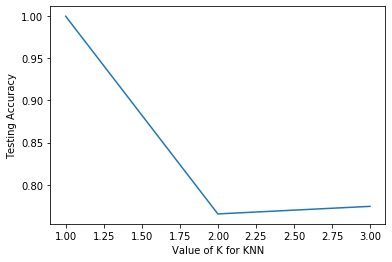

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

# try K=1 through K=X and note the testing accuracy
k_range = range(1, 4)

scores = []

for k in k_range:
    knn = KNeighborsClassifier(k) # We set the number of neighbors to 15
    knn.fit(x_train, y_train)
    y_predicted = knn.predict(x_validation)
    scores.append(accuracy_score(y_validation, y_predicted))
    print('Loop:', k ,'accuracy ', accuracy_score(y_validation, y_predicted))

#plot_decision_regions(x_train[:500].to_numpy(), y_train.astype(np.integer)[:500].to_numpy(), clf=knn, feature_index = [0,1], res=0.1); # This is a slow classifier, so we reduce the resolution    

# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

#https://www.ritchieng.com/machine-learning-k-nearest-neighbors-knn/